# How to solve Inverse Kinematics of a four-legged Robot

What is Inverse Kinematics / IK? 
A RobotLeg consists of 3 Servos rotating things from angle amin to angle amax.
When we know all three angles, we can determine the TargetPoint of the Leg by simple School-Math (remember sin and cos?).

This is what is called "Forward Kinematics". Inverse Kinematics is, you can imagine, the inverse. 
So, we have a Point and want to know the angles of our Servos. This can become pretty challenging when having more than 3-DOF (Degrees of Freedom). But in our case it's quite trivial.

See [this Page](https://www.ijstr.org/final-print/sep2017/Inverse-Kinematic-Analysis-Of-A-Quadruped-Robot.pdf) for more Information about Inverse Kinematics for quadruped Robots.
We will have to do our own calculations, since SpotMicro has some specialities which are not included a those formulas.

When you take a look at Fig. 2 you will notice, that the Leg used here is quite similar to 
SpotMicros Leg, but not really the same:

- the "Leg"-Motor/Rotation is on the same axis (z3) as the Shoulder-Motor/Rotation-Axis.
  SpotMicros Leg-Rotation is about 1cm lower, so we need an additional "L1b" which goes down (same direction as L2),
  but does not rotate with the Leg (L2,L3). Since we are completely recreating the calculations, i decided to go with
  L1-L4 instead of L1,L1b,L2,L3. 
- the "Foot"-joint is shifted by ~1cm to "the front" (pictures will follow). 

<IPython.core.display.Javascript object>


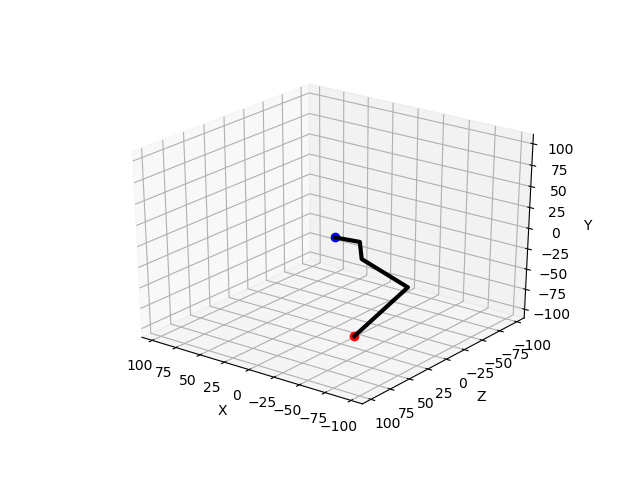

t1 5.641557408312655 t2 -44.214309032200575 t3 115.538242734043


'\nfor z in range(-100,100,50):\n    plotall(x+25,y,z)\n    plotall(x-50,y,z)\n    #plotall(x-100,y,z)\n'

In [594]:
%matplotlib notebook

from mpl_toolkits import mplot3d
import  numpy as np
import math
import matplotlib.pyplot as plt

ax = plt.axes(projection="3d")

ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)
ax.set_zlim(-200, 200)
ax.set_xlabel("X")
ax.set_ylabel("Z")
ax.set_zlabel("Y")

# Lengths of Segments in mm

l1=25
l2=20
l3=80
l4=80

def plotall(x,y,z):

    # IK
    
    # Length of shoulder-point to target-point on x/y only
    F=math.sqrt(x**2+y**2-l1**2)
    # G is the length we need to reach to the point on x/y
    G=F-l2  
    # get the 3-Dimensional length we need to reach
    H=math.sqrt(G**2+z**2)

    theta1=-math.atan2(-y,x)-math.atan2(F,-l1)
    
    D=(H**2-l3**2-l4**2)/(2*l3*l4)
    theta3=math.acos(D) 
    
    theta2=math.atan2(z,G)-math.atan2(l4*math.sin(theta3),l3+l4*math.cos(theta3))
    
    # Draw it

    plt.plot([0],[0],[0],'bo',lw=2)
    plt.plot([x],[z],[-y],'ro',lw=2)
    
    l1x=-l1*math.cos(theta1)
    l1y=l1*math.sin(theta1)
    l1z=0

    l2x=l1x-l2*math.sin(theta1)
    l2y=l1y-l2*math.cos(theta1)
    l2z=0

    l3x=l2x-l3*math.sin(theta1)*math.cos(theta2)
    l3y=l2y-l3*math.cos(theta1)*math.cos(theta2)
    l3z=l2z+l3*math.sin(theta2)

    t4=theta2+theta3
    l4x=l3x-l4*math.sin(theta1)*math.cos(t4)
    l4y=l3y-l4*math.cos(theta1)*math.cos(t4)
    l4z=l3z+l4*math.sin(t4)

    plt.plot([0,l1x,l2x,l3x, l4x], [0,l1z,l2z,l3z, l4z],[0,l1y,l2y,l3y,l4y], 'k-', lw=3)

    print("t1 {} t2 {} t3 {}".format(theta1/(math.pi/180),theta2/(math.pi/180),theta3/(math.pi/180)))

x=-35
y=100
z=20

plotall(x,y,z)

"""
for z in range(-100,100,50):
    plotall(x+25,y,z)
    plotall(x-50,y,z)
    #plotall(x-100,y,z)
"""


## Leg IK

So let's take a look at SpotMicro's Legs:

![Leg in Space](../Images/leg_in_space.jpg)

First of all lets focus on the shoulder-angle - theta1.
The Paper uses

![Original](https://latex.codecogs.com/gif.latex?%5Ctheta_%7B1%7D%20%3D%20-atan2%28-y%2Cx%29%20-%20atan2%28%5Csqrt%7Bx%5E2&plus;y%5E2-L1%5E2%7D%2C-L1%29)

![theta2](https://latex.codecogs.com/gif.latex?%5Ctheta_%7B2%7D%3Datan2%28z%2C%5Csqrt%7Bx%5E2&plus;y%5E2-L%7B_%7B1%7D%7D%5E2%7D%29-atan2%28L_%7B3%7Dsin%28%5Ctheta_%7B3%7D%29%2CL_%7B2%7D&plus;L_%7B3%7Dcos%28%5Ctheta_%7B3%7D%29%29)

![theta3](https://latex.codecogs.com/gif.latex?%5Ctheta_%7B3%7D%3Datan2%28%5Csqrt%7B1-D%5E2%7D%2CD%29)

![D](https://latex.codecogs.com/gif.latex?D%3D%28X%5E2&plus;Y%5E2-L%7B_%7B1%7D%7D%5E2&plus;Z%5E2-L%7B_%7B2%7D%7D%5E2-L%7B_%7B3%7D%7D%5E2%29/%282L%7B_%7B2%7D%7DL_%7B3%7D%29)

Let's discover that.
We need some kind of toolbelt for this mission.

### Tool 1: Pythagoras

Calculate the missing edge-length of a triangle with a 90° angle. 

![Pythagoras](https://latex.codecogs.com/gif.latex?a%5E2&plus;b%5E2%3Dc%5E2)

![Pythagoras](https://latex.codecogs.com/gif.latex?a%5E2%3Dc%5E2-b%5E2)

![Pythagoras](https://latex.codecogs.com/gif.latex?b%5E2%3Dc%5E2-a%5E2)

and so 

![Pythagoras](https://latex.codecogs.com/gif.latex?c%3D%5Csqrt%5B%5D%7Ba%5E2&plus;b%5E2%7D)

![Pythagoras](https://latex.codecogs.com/gif.latex?a%3D%5Csqrt%5B%5D%7Bc%5E2-b%5E2%7D)

![Pythagoras](https://latex.codecogs.com/gif.latex?b%3D%5Csqrt%5B%5D%7Bc%5E2-a%5E2%7D)

### Tool 2: atan2(y,x) - get the angle of Point(x,y) from Origin (square-angle needed)

Please see [Wikipedia](https://en.wikipedia.org/wiki/Atan2). They did a great job in explaining it. 

### Tool 2b: get alpha angle of triangle when all sides are known

![google](https://latex.codecogs.com/gif.latex?%5Calpha%3Dacos%28%20%28%20a%5E2%20&plus;%20b%5E2%20-%20c%5E2%20%29%20/%20%282ab%29%20%29)

and yes, knowing that:

![atan2](https://latex.codecogs.com/gif.latex?acos%28D%29%3Datan2%28%5Csqrt%7B1-D%5E2%7D%2CD%29)

it looks very similar to:

![D](https://latex.codecogs.com/gif.latex?D%3D%28X%5E2&plus;Y%5E2-L%7B_%7B1%7D%7D%5E2&plus;Z%5E2-L%7B_%7B2%7D%7D%5E2-L%7B_%7B3%7D%7D%5E2%29/%282L%7B_%7B2%7D%7DL_%7B3%7D%29)

![theta3](https://latex.codecogs.com/gif.latex?%5Ctheta_%7B3%7D%3Datan2%28%5Csqrt%7B1-D%5E2%7D%2CD%29)


### solving theta1 

![theta1](../Images/leg_front_notsolved.jpg)

If we could solve E and F, we could calculate the angles and we have theta1!

![theta1](../Images/leg_front_solved.jpg)

F is quite easy, as Pythagoras told us. And then E is quite easy too. Pythagoras again. 
Now we have a Triangle with L1,E and F, and it has a square-angle. Perfect for atan2!
So we calculate the whole angle alpha of the triangle and then substract the angle 
of the lower part by using atan2 again with -y and x. Great!

And now we have E. And E-L2 is "how long must the two joints leg and foot be (on X/Y only) to reach point Pxy".
We call it G.

![g](https://latex.codecogs.com/gif.latex?G%20%3D%20%5Csqrt%7Bx%5E2&plus;y%5E2-L%7B_%7B1%7D%7D%5E2%7D-L_%7B2%7D)

So now we can say H is the "needed length of our joints in X,Y,Z". Thank you Pythagoras, again.

![h](https://latex.codecogs.com/gif.latex?H%20%3D%20%5Csqrt%7B%28%5Csqrt%7Bx%5E2&plus;y%5E2-L%7B_%7B1%7D%7D%5E2%7D-L_%7B2%7D%29%5E2&plus;z%5E2%7D)


### solving theta3

We know what length we need to reach with the leg and foot-joint. It's a simple triangle.
All sides are known. L3,L4 and H.

![D](https://latex.codecogs.com/gif.latex?D%20%3D%20%28L%7B_%7B3%7D%7D%5E2&plus;L%7B_%7B4%7D%7D%5E2-H%5E2%29/%282L_%7B3%7DL_%7B4%7D%29)

![theta3](https://latex.codecogs.com/gif.latex?%5Ctheta_%7B3%7D%3Datan2%28%5Csqrt%7B1-D%5E2%7D%2CD%29)


### solving theta2

The last one, theta2. This one is quite easy:

Formula will follow
